In [1]:
import torch
import torch.nn as nn
import numpy as np
from typing import Callable
from spikingjelly.clock_driven import neuron, surrogate, base, functional
from spikingjelly import visualizing
from matplotlib import pyplot as plt
import time
import plotly.express as px

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\cupy\_environment.py:435: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda113

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


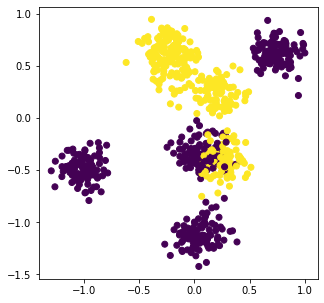

In [2]:
from script import make_dataset
plt.rcParams['figure.figsize'] = (5, 5)
xx, y = make_dataset()
x=xx/xx.max()

plt.scatter(x[:, 0], x[:, 1], c=y[:, 0])
plt.show()

In [21]:
class AlteredSigmoid(surrogate.Sigmoid):
    def __init__(self, alpha=1.0, spiking=True):
        super().__init__(alpha, spiking)

    @staticmethod
    def spiking_function(x, alpha):
        return torch.floor(torch.relu(x))

    @staticmethod
    def primitive_function(x: torch.Tensor, alpha):
        return (x * alpha).sigmoid()*torch.floor(x)


class HisIFNode(neuron.IFNode):
    def __init__(self, v_threshold: float = 1., detach_reset: bool = False,
                 surrogate_function: Callable = AlteredSigmoid()):
        super().__init__(v_threshold, None, surrogate_function, detach_reset)

        self.history_inp=[]
        self.history_v = []
        self.history_s = []
        self.history_n = []

    def forward(self, x: torch.Tensor):
        out=super().forward(torch.round(x*10**4)/10**4)

        if len(self.history_n)==0:
            self.history_inp=[torch.clone(self.spike)*0]
            self.history_v = [torch.clone(self.spike)*0]
            self.history_s = [torch.clone(self.spike)*0]
            self.history_n = [torch.clone(self.spike)*0]

        self.history_inp.append(torch.clone(x))
        self.history_v.append(torch.clone(self.v))
        self.history_s.append(torch.clone(self.spike))
        self.history_n.append(torch.clone(self.history_n[-1] + self.spike))

        return out

    def reset(self):
        super().reset()

        self.history_inp=[]
        self.history_v = []
        self.history_s = []
        self.history_n = []


class AIFNode(HisIFNode):
    def __init__(self, v_threshold: float = 1., detach_reset: bool = False,
                 surrogate_function: Callable = AlteredSigmoid()):
        super().__init__(v_threshold, detach_reset, surrogate_function)
        self.to('cuda')

    def neuronal_fire(self):
        self.spike = self.surrogate_function(torch.round((self.v-self.v_threshold)*10**4)/10**4)


class SNNSigmoid(nn.Sigmoid):
    def __init__(self):
        super().__init__()
        self.history_n = None
        self.time_step = 0

    def forward(self, input):
        if self.history_n is None: self.history_n = torch.clone(input)
        else: self.history_n += input
        self.time_step += 1
        out=super().forward(self.history_n/self.time_step)
        return out

    def reset(self):
        self.history_n = None
        self.time_step = 0


class TimedLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args)
        self.proc_time = [0]

    def forward(self, input):
        s_ = int(len(input.shape)!=1)
        self.proc_time += [self.proc_time[-1]+
                    (input!=0).sum(s_)*len(self.weight)+
                    (self.bias>0).sum()+
                    ((input!=0).sum(s_)>0)*(self.bias<0).sum()]

        return super().forward(input)

    def reset(self):
        self.proc_time = [0]


class TimedLinearANN(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args)
        self.proc_time = [0]

    def forward(self, input):
        self.proc_time += [self.proc_time[-1]+(2*len(self.weight)+1)*len(self.weight[0])]
        if len(input.shape)!=1: self.proc_time[-1] = (input.sum(1)*0)+self.proc_time[-1]
        return super().forward(input)

    def reset(self):
        self.proc_time = [0]

In [22]:
class SNN(nn.Module):
    def __init__(self, v_threshold=1.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 4),
            AIFNode(),
            nn.Linear(4, 4),
            AIFNode(),
            nn.Linear(4, 2),
            SNNSigmoid()
        )

    def forward(self, x):
        return self.fc(x)

class IF_SNN(nn.Module):
    def __init__(self, v_threshold=1.0):
        super().__init__()
        self.fc = nn.Sequential(
            TimedLinearANN(2, 4),
            HisIFNode(),
            TimedLinear(4, 4),
            HisIFNode(),
            TimedLinear(4, 2),
            SNNSigmoid()
        )

    def forward(self, x):
        return self.fc(x)

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            TimedLinearANN(2, 4),
            nn.ReLU(),
            TimedLinearANN(4, 4),
            nn.ReLU(),
            TimedLinearANN(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

In [72]:
torch.cuda.empty_cache()

ori_ann=ANN()
mod_ann=ANN()
snnto_ann=ANN()
ori_aif_snn=SNN()
aif_snn=SNN()
if_snn=IF_SNN()

ori_ann.to('cuda')
mod_ann.to('cuda')
snnto_ann.to('cuda')
ori_aif_snn.to('cuda')
aif_snn.to('cuda')
if_snn.to('cuda')

# train model on x and y
x_tensor = torch.tensor(x, dtype=torch.float32, device='cuda')
y_tensor = torch.tensor(y, dtype=torch.float32, device='cuda')

optimizer = torch.optim.Adam(ori_ann.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
for epoch in range(2000+1):
    prediction = ori_ann(x_tensor)
    loss = loss_func(prediction, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 400 == 0: print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy())

Epoch:  0 | train loss: 0.6864
Epoch:  400 | train loss: 0.3673
Epoch:  800 | train loss: 0.3654
Epoch:  1200 | train loss: 0.3651
Epoch:  1600 | train loss: 0.3649
Epoch:  2000 | train loss: 0.3641


In [73]:
import sys, importlib
importlib.reload(sys.modules['script'])
from script import ann_max_norm, snn_max_norm

# copy ori_ann weights
torch.cuda.empty_cache()
functional.reset_net(ori_aif_snn)
functional.reset_net(aif_snn)
functional.reset_net(if_snn)

mod_ann.load_state_dict(ori_ann.state_dict())
snnto_ann.load_state_dict(ori_ann.state_dict())
ori_aif_snn.load_state_dict(ori_ann.state_dict())
aif_snn.load_state_dict(ori_ann.state_dict())
if_snn.load_state_dict(ori_ann.state_dict())

# max norm mod ann
mod_ann.load_state_dict(ori_ann.state_dict())
ann_max_norm(x_tensor,mod_ann, m=1,only_mul=False)

# prevent more than one spike in one time step on AIF model
aif_snn.load_state_dict(mod_ann.state_dict())
snn_max_norm(x_tensor,aif_snn, 100)

# more weights to IF model
if_snn.load_state_dict(aif_snn.state_dict())
snnto_ann.load_state_dict(if_snn.state_dict())

# etc
# if_snn.load_state_dict(mod_ann.state_dict())

<All keys matched successfully>

In [74]:
torch.cuda.empty_cache()
ann_x = torch.clone(x_tensor)
for i,l in enumerate(mod_ann.fc):
    with torch.no_grad(): ann_x=l(ann_x)
    if type(l) is not nn.ReLU: continue
    print(torch.quantile(ann_x,0.999,0,False,interpolation='lower'),type(l))

print('*******')
torch.cuda.empty_cache()
functional.reset_net(aif_snn)
with torch.no_grad():
    for _ in range(2000-1): aif_snn(x_tensor)
for i,l in enumerate(aif_snn.fc):
    if type(l) is not AIFNode: continue
    print(torch.quantile(torch.cat(l.history_s),0.999,0,False,interpolation='lower'),type(l))

tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0') <class 'torch.nn.modules.activation.ReLU'>
tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0') <class 'torch.nn.modules.activation.ReLU'>
*******
tensor([1., 1., 1., 1.], device='cuda:0') <class '__main__.AIFNode'>
tensor([1., 1., 1., 1.], device='cuda:0') <class '__main__.AIFNode'>


In [78]:
for model in [ori_ann,mod_ann,snnto_ann]:
    torch.cuda.empty_cache()
    plt.rcParams['figure.figsize'] = (11, 5)
    with torch.no_grad():
        functional.reset_net(model)
        start_time = time.time()
        pred_ann_y=model(x_tensor)
        end_time = time.time()
    print(f"The execution time is: {end_time-start_time}")
    print('loss =',loss_func(pred_ann_y, y_tensor))

    # fig, ax=plt.subplots(1,2)
    # ax[0].scatter(x[:, 0], x[:, 1], c=pred_ann_y.data.cpu().numpy()[:, 0])
    # ax[1].scatter(x[:, 0], x[:, 1], c=pred_ann_y.data.cpu().numpy()[:, 1])
    # plt.show()

The execution time is: 0.00400090217590332
loss = tensor(0.3641, device='cuda:0')
The execution time is: 0.0009999275207519531
loss = tensor(0.3641, device='cuda:0')
The execution time is: 0.0009989738464355469
loss = tensor(0.3641, device='cuda:0')


In [76]:
for model in [ori_aif_snn,aif_snn,if_snn]:
    torch.cuda.empty_cache()
    plt.rcParams['figure.figsize'] = (11, 5)
    with torch.no_grad():
        functional.reset_net(model)
        start_time = time.time()
        for _ in range(100-1): model(x_tensor)
        pred_snn_y=model(x_tensor)
        end_time = time.time()
    print(f"The execution time is: {end_time-start_time}")
    print('loss =',loss_func(pred_snn_y, y_tensor))

    # fig, ax=plt.subplots(1,2)
    # ax[0].scatter(x[:, 0], x[:, 1], c=pred_snn_y.data.cpu().numpy()[:, 0])
    # ax[1].scatter(x[:, 0], x[:, 1], c=pred_snn_y.data.cpu().numpy()[:, 1])
    # plt.show()

The execution time is: 0.06552314758300781
loss = tensor(0.3642, device='cuda:0')
The execution time is: 0.06114029884338379
loss = tensor(0.3668, device='cuda:0')
The execution time is: 0.11619019508361816
loss = tensor(0.3670, device='cuda:0')


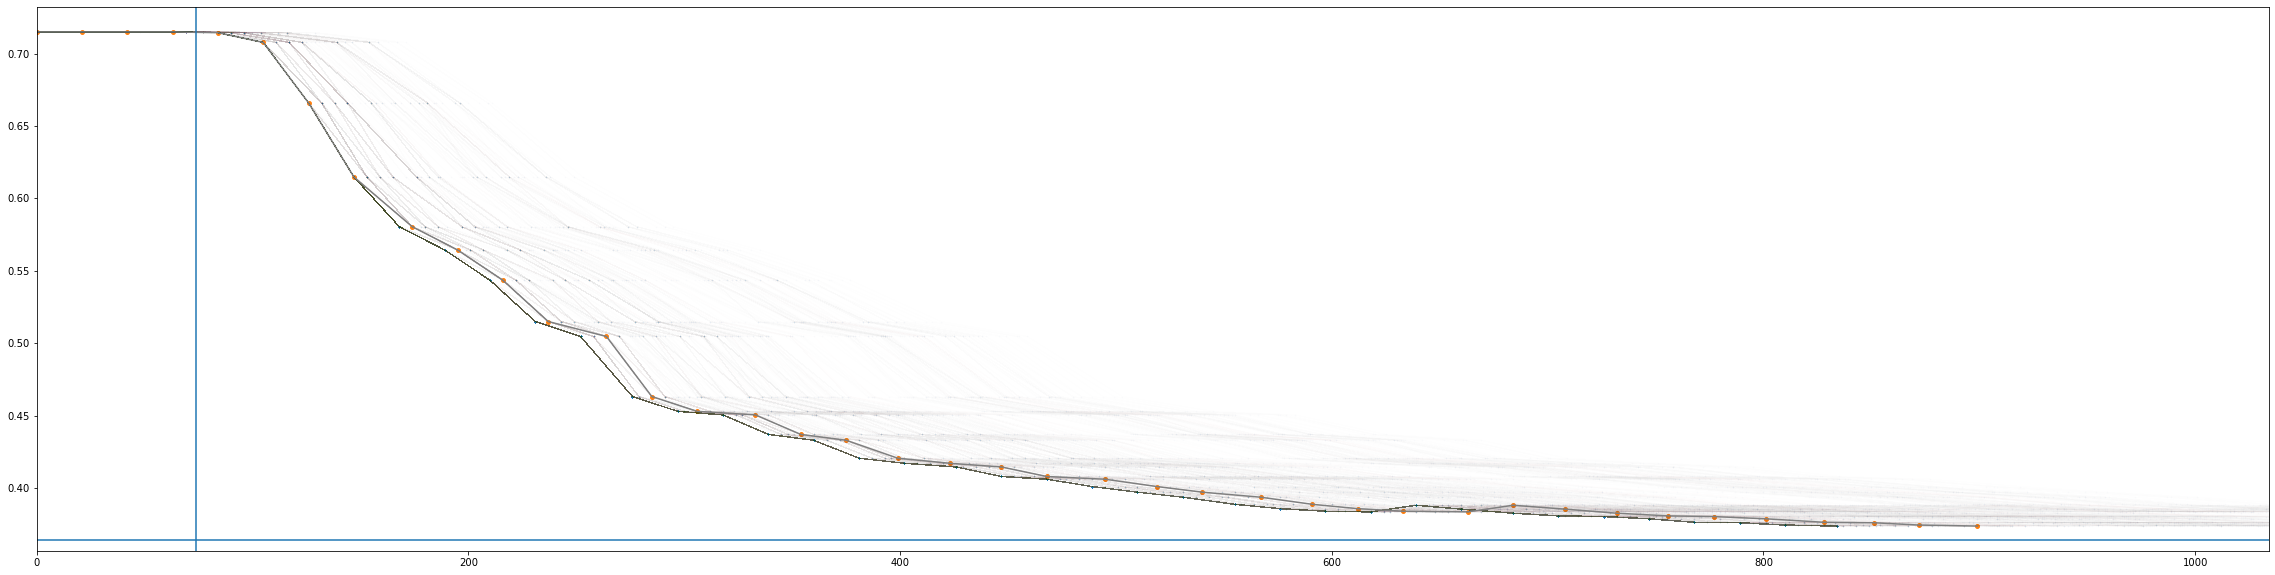

In [95]:
import sys, importlib
importlib.reload(sys.modules['script'])

from script import plot_delta_r_comparison, check_neg_error, proc_vs_acc
# check_neg_error(if_snn,snnto_ann,x_tensor,500, ylim=0.001)

# i=np.random.choice(x.shape[0])
# plot_delta_r_comparison(if_snn,snnto_ann,x_tensor[613], ylim=0.015, xmlim=-0.1, xlim=1000)

proc_vs_acc(if_snn,snnto_ann,x_tensor,y_tensor,40,ylim=None)